# TensorFlow Recommenders beachhead
Xiaolan Li

This project uses TensorFlow recommendation framwork to define the model and do the prediction for users. The framework is mainly processing in an implicit dataset without using rating scale.

The model consists of two parts: 

`The query tower`: the model that is responsible for learning the user embeddings. 

`The candidate tower`: the model that is responsible for learning the movie embeddings.




## Reading Data

In [1]:
import pandas as pd
df_books = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/books/books.csv')

In [2]:
df_books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [3]:
df_ratings = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/books/ratings.csv')

In [4]:
df_ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [5]:
print(df_ratings.shape)
print('user_id', df_ratings.user_id.nunique())
print('book_id',df_ratings.book_id.nunique())
df_ratings.isnull().sum()

(981756, 3)
user_id 53424
book_id 10000


book_id    0
user_id    0
rating     0
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
# take 80% for the training set and the remaining 20% for the validation set.
Xtrain, Xtest = train_test_split(df_ratings, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (785404, 3)
Shape of test data: (196352, 3)


## Building the Recommendation Engine

### Define neural network

In [7]:
import tensorflow as tf

def BooksModel(nbook_id, nuser_id, embeddingLayers):
    # Book input network
    # create an input layer to accept a 1D array of book IDs
    input_books = tf.keras.layers.Input(shape=[1])
    """
    create an embedding layer with a shape of (number of unique books + 1, embeddingLayers),
    add 1 because the embedding layers need an extra row for books 
    that do not appear in the training dataset
    """
    embed_books = tf.keras.layers.Embedding(nbook_id + 1,embeddingLayers)(input_books)
    books_out = tf.keras.layers.Flatten()(embed_books)

    # user input network
    input_users = tf.keras.layers.Input(shape=[1])
    embed_users = tf.keras.layers.Embedding(nuser_id + 1,embeddingLayers)(input_users)
    users_out = tf.keras.layers.Flatten()(embed_users)

    # concatenate the books and the user embedding layer together
    conc_layer = tf.keras.layers.Concatenate()([books_out, users_out])
    # add a single dense layer with 128 nodes on top of it
    x = tf.keras.layers.Dense(128, activation='relu')(conc_layer)
    # use a single node to predict the ratings given to each book
    x_out = x = tf.keras.layers.Dense(1, activation='relu')(x)
    # create a single model from our defined architecture
    model = tf.keras.Model([input_books, input_users], x_out)
    
    return model

### Compile, fit and evaluate it

In [8]:
def evaluateModel(model, epochs):
    """Using an Adam optimizer here with a learning rate of 0.001, 
    and mean squared error as the loss function"""
    opt = tf.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mean_squared_error')
    model.summary()

    # batch size of 64 to have a fatster training
    hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                     batch_size=64, 
                     epochs=epochs, 
                     verbose=1,
                     validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))
    return hist


In [9]:
import matplotlib.pyplot as plt
def plotLoss_Model(hist):
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(train_loss, color='r', label='Train Loss')
    plt.plot(val_loss, color='b', label='Validation Loss')
    plt.title("Train and Validation Loss Curve")
    plt.legend()
    plt.show()

### Test the model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
______________________________________________________________________________________________

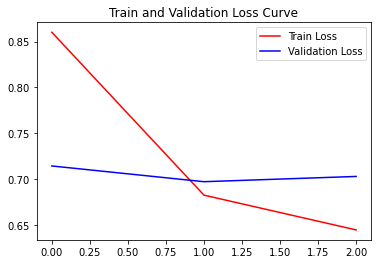

In [10]:
#Get the number of unique entities in books and users columns
nbook_id = df_ratings.book_id.nunique()
nuser_id = df_ratings.user_id.nunique()

# setting the layers as 15
model = BooksModel(nbook_id, nuser_id, 15)
hist = evaluateModel(model = model, epochs = 3)
plotLoss_Model(hist)

## Making Recommendation for users

In [11]:
import numpy as np

#Making recommendations for user 100
b_id =list(df_ratings.book_id.unique())
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])
pred = model.predict([book_arr, user])
pred

array([[4.043408 ],
       [4.2419095],
       [2.8171525],
       ...,
       [4.134322 ],
       [3.627077 ],
       [3.9673584]], dtype=float32)

In [17]:
# sorting the array, and retrieve the index of the highest 5
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = pred.argsort()[0:5]
pred_ids

array([1792, 4044,   33, 7635, 4281], dtype=int64)

In [18]:
df_books.iloc[pred_ids]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
1792,1793,105578,105578,101770,25,345498321,9.780345e+12,Chetan Bhagat,2005.0,One Night @ The Call Center,...,40718,44833,1244,10559,14125,11872,5177,3100,https://images.gr-assets.com/books/1320500924m...,https://images.gr-assets.com/books/1320500924s...
4044,4045,22874559,22874559,42438620,8,8129135728,9.788129e+12,Chetan Bhagat,2014.0,Half Girlfriend,...,22082,27146,2067,3207,5052,7855,6343,4689,https://images.gr-assets.com/books/1407223058m...,https://images.gr-assets.com/books/1407223058s...
33,34,10818853,10818853,15732562,169,1612130291,9.781612e+12,E.L. James,2011.0,Fifty Shades of Grey,...,1338493,1436818,75437,165455,152293,252185,294976,571909,https://images.gr-assets.com/books/1385207843m...,https://images.gr-assets.com/books/1385207843s...
7635,7636,7011879,7011879,7257194,7,8188575658,9.788189e+12,"Durjoy Datta, Maanvi Ahuja",2008.0,of course i love you,...,6671,9661,301,1059,1663,2910,2203,1826,https://images.gr-assets.com/books/1274597947m...,https://images.gr-assets.com/books/1274597947s...
4281,4282,4601396,4601396,4651129,50,385526342,9.780386e+12,Chuck Palahniuk,2009.0,Pygmy,...,21242,22865,1782,3121,4811,7258,5192,2483,https://images.gr-assets.com/books/1320495043m...,https://images.gr-assets.com/books/1320495043s...


## Reference

https://www.tensorflow.org/api_docs/python/tf/keras/Model

https://towardsdatascience.com/intro-to-recommender-systems-with-tensorflow-and-tfrs-c4d7fdacd0a4

https://heartbeat.fritz.ai/build-train-and-deploy-a-book-recommender-system-using-keras-tensorflow-js-b96944b936a7

https://www.tensorflow.org/recommenders/examples/basic_retrieval